In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, math, time, random
from pathlib import Path
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ddim import build_conditional_ddim
import utils

/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Repro
seed = 123
random.seed(seed); torch.manual_seed(seed); 
if device.type == "cuda": torch.cuda.manual_seed_all(seed)

ROOT = Path("./ddim_unit_tests")
ROOT.mkdir(exist_ok=True, parents=True)

Device: cuda


In [4]:
cl_cifar_train_loaders, cl_cifar_test_loaders, cifar_train_loader, cifar_test_loader = utils.get_cl_dataset('cifar10', batch_size=128, normalize=True, greyscale=False)
cl_mnist_train_loaders, cl_mnist_test_loaders, mnist_train_loader, mnist_test_loader = utils.get_cl_dataset('mnist', batch_size=128, normalize=True, greyscale=True)

Building DataLoaders for each class in train dataset...


100%|██████████| 50000/50000 [00:07<00:00, 6736.40it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 6707.51it/s]


Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:08<00:00, 6710.33it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:01<00:00, 6864.53it/s]


In [7]:
mnist_model = build_conditional_ddim(
    in_channel=1,
    image_size=32,
    # block_out_channels=(16, 16),
    # down_block_types=("DownBlock2D","DownBlock2D"),
    # up_block_types=("UpBlock2D","UpBlock2D"),
    # norm_num_groups=8,
    # layers_per_block=1,
    num_class_labels=4,
).to(device)

# print # params
print("MNIST model parameters:", sum(p.numel() for p in mnist_model.parameters() if p.requires_grad))

cifar_model = build_conditional_ddim(
    in_channel=3,
    image_size=32,
    # block_out_channels=(16, 16),
    # down_block_types=("DownBlock2D","DownBlock2D"),
    # up_block_types=("UpBlock2D","UpBlock2D"),
    # norm_num_groups=8,
    # layers_per_block=1,
    num_class_labels=2,
).to(device)

print("CIFAR model parameters:", sum(p.numel() for p in cifar_model.parameters() if p.requires_grad))


mnist_opt = optim.Adam(mnist_model.parameters(), lr=2e-4)#, weight_decay=1e-4)
cifar_opt = optim.Adam(cifar_model.parameters(), lr=2e-4)#, weight_decay=1e-4)


MNIST model parameters: 35743745
CIFAR model parameters: 35747331


In [17]:
n_epochs = 200
# utils.train_one_task(cifar_model, cl_cifar_train_loaders[0], 0, cifar_opt, None, n_epochs, ROOT, device)
utils.train_one_task(mnist_model, cl_mnist_train_loaders[0], 0, mnist_opt, None, n_epochs, ROOT, device)
# save the model
model_path = ROOT / "mnist_model_large.pth"
torch.save(mnist_model.state_dict(), model_path)

100%|██████████| 200/200 [1:15:40<00:00, 22.70s/it]


In [8]:
# load the model
cifar_model.load_state_dict(torch.load( ROOT / "cifar_model.pth", map_location=device))
mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large.pth", map_location=device))

<All keys matched successfully>

In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

@torch.no_grad()
def _maybe_to(x, device):
    return x.to(device) if x.device != device else x

def compute_param_scores(
    model,
    t_level: int,
    loaders_by_class,          # e.g., your cl_mnist_train_loaders dict
    device: torch.device = torch.device("cuda"),
    target_class: int = 0,     # match your `if class_id != 0: continue`
    max_samples: int | None = None,
):
    """
    Compute per-sample parameter scores (gradients) for a DDPM-style model.

    Args:
        model: object with attributes `unet` and `scheduler`. The UNet forward should be
               compatible with (noisy_x, t[, labels]) and may return either a tensor or
               an object with `.sample`.
        t_level (int): fixed diffusion timestep to use.
        loaders_by_class (dict[int, DataLoader]): mapping class_id -> DataLoader yielding (images, labels).
        device (torch.device): device for computation.
        target_class (int): which class_id to use from `loaders_by_class`.
        max_samples (int|None): stop after collecting this many samples (None = all).

    Returns:
        param_scores: Tensor of shape (N, D) where N is number of samples processed and
                      D is the number of trainable parameters in `model.unet`.
    """
    model.eval()
    model = model.to(device)

    # Convenience handles
    unet = model.unet
    scheduler = model.scheduler

    param_scores = []
    n_collected = 0

    # Get the loader for the desired class
    if target_class not in loaders_by_class:
        raise KeyError(f"class_id {target_class} not found in loaders_by_class")
    loader = loaders_by_class[target_class]

    # Ensure autograd is enabled (we need grads!)
    # torch.set_grad_enabled(True)

    for images, labels in tqdm(loader, desc=f"param_scores@t={t_level}"):
        images = _maybe_to(images, device)
        labels = _maybe_to(labels, device)

        # Loop per-sample to get per-sample grads (simple and faithful to your code)
        for img, label in zip(images, labels):
            img = img.unsqueeze(0)     # (1, C, H, W)
            label = label.unsqueeze(0) # (1,)

            # Fix timestep t
            # random t in [0, 1000)
            t = torch.randint(0, 1000, (1,), device=device, dtype=torch.long)
            # t = torch.full((1,), int(t_level), device=device, dtype=torch.long)

            # Add noise
            noise = torch.randn_like(img, device=device)
            noisy_x = scheduler.add_noise(img, noise, t)

            # Forward UNet (handle conditional/unconditional + output types)
            try:
                out = unet(noisy_x, t, label)
            except TypeError:
                out = unet(noisy_x, t)

            pred_noise = out.sample if hasattr(out, "sample") else out

            # Compute per-sample loss and backward for grads w.r.t. UNet params
            unet.zero_grad()
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()

            # Flatten/concat gradients into one vector
            grads = []
            for p in unet.parameters():
                if p.requires_grad and p.grad is not None:
                    grads.append(p.grad.reshape(-1))
            if not grads:
                raise RuntimeError("No gradients found on UNet parameters.")
            g_vec = torch.cat(grads).detach().cpu()  # (D,)
            param_scores.append(g_vec)

            n_collected += 1
            if max_samples is not None and n_collected >= max_samples:
                break

        if max_samples is not None and n_collected >= max_samples:
            break

    # Stack into (N, D)
    if len(param_scores) == 0:
        raise RuntimeError("Collected zero param_scores. Check your data and forward pass.")
    param_scores = torch.stack(param_scores, dim=0).to(device)
    return param_scores

In [9]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

@torch.no_grad()
def _maybe_to(x, device):
    return x.to(device) if x.device != device else x

def compute_rank1_coeff_and_mean(
    model,
    t_level: int,
    loaders_by_class,                 # dict[int, DataLoader] yielding (images, labels)
    device: torch.device = torch.device("cuda"),
    target_class: int = 0,
    max_samples: int | None = None,
    eps: float = 1e-12,
    dtype: torch.dtype = torch.float64,  # use float64 for stable inner products
):
    """
    Streaming, two-pass computation of:
      - mu: E[g]  (flattened over all trainable UNet parameters)
      - c*: optimal rank-1 coefficient along mu mu^T:
            c* = E[(mu^T g)^2] / ||mu||^4
    No (B,D) allocation; only a running mean and scalar accumulators.

    Returns:
      c_star (scalar tensor on `device` with `dtype`)
      mu     (1-D tensor of length D on `device` with `dtype`)
    """
    model.eval()
    model = model.to(device)

    unet = model.unet
    scheduler = model.scheduler

    if target_class not in loaders_by_class:
        raise KeyError(f"class_id {target_class} not found in loaders_by_class")
    loader = loaders_by_class[target_class]

    torch.set_grad_enabled(True)

    # ---------------- PASS 1: compute mu = E[g] ----------------
    mu = None
    diag_sum = None
    N = 0

    pbar = tqdm(loader, desc=f"[pass1] mu @ t={t_level}")
    for images, labels in pbar:
        images = _maybe_to(images, device)
        labels = _maybe_to(labels, device)

        for img, label in zip(images, labels):
            img = img.unsqueeze(0)
            label = label.unsqueeze(0)

            # t = torch.full((1,), int(t_level), device=device, dtype=torch.long)
            # random t in [0, 1000)
            t = torch.randint(0, 1000, (1,), device=device, dtype=torch.long)
            noise = torch.randn_like(img, device=device)
            noisy_x = scheduler.add_noise(img, noise, t)

            try:
                out = unet(noisy_x, t, label)
            except TypeError:
                out = unet(noisy_x, t)

            pred_noise = out.sample if hasattr(out, "sample") else out

            unet.zero_grad(set_to_none=True)
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()

            # flatten current sample's gradient
            grads = [p.grad.reshape(-1) for p in unet.parameters() if p.requires_grad and p.grad is not None]
            if not grads:
                raise RuntimeError("No gradients found on UNet parameters.")
            g = torch.cat(grads).to(dtype)

            if mu is None:
                mu = torch.zeros_like(g, device=device, dtype=dtype)
                diag_sum = torch.zeros_like(g, device=device, dtype=dtype)

            mu += g
            diag_sum += g * g  # accumulate ||g||^2 for each sample
            N += 1

            unet.zero_grad(set_to_none=True)  # free grads ASAP

            if max_samples is not None and N >= max_samples:
                break
        if max_samples is not None and N >= max_samples:
            break

    if mu is None or N == 0:
        raise RuntimeError("Collected zero gradients. Check data/forward pass.")
    mu /= float(N)
    F_diag = diag_sum / float(N)  # E[||g||^2] per parameter
    mu_norm2 = (mu @ mu)

    if mu_norm2 <= eps:
        # Degenerate direction; best rank-1 coeff is 0
        return torch.zeros((), device=device, dtype=dtype), mu

    # ---------------- PASS 2: compute a = E[(mu^T g)^2] ----------------
    sum_proj2 = torch.zeros((), device=device, dtype=dtype)
    M = 0

    pbar = tqdm(loader, desc=f"[pass2] c* @ t={t_level}")
    for images, labels in pbar:
        images = _maybe_to(images, device)
        labels = _maybe_to(labels, device)

        for img, label in zip(images, labels):
            img = img.unsqueeze(0)
            label = label.unsqueeze(0)

            # t = torch.full((1,), int(t_level), device=device, dtype=torch.long)
            # random t in [0, 1000)
            t = torch.randint(0, 1000, (1,), device=device, dtype=torch.long)
            noise = torch.randn_like(img, device=device)
            noisy_x = scheduler.add_noise(img, noise, t)

            try:
                out = unet(noisy_x, t, label)
            except TypeError:
                out = unet(noisy_x, t)
            pred_noise = out.sample if hasattr(out, "sample") else out

            unet.zero_grad(set_to_none=True)
            loss = F.mse_loss(pred_noise, noise)
            loss.backward()

            grads = [p.grad.reshape(-1) for p in unet.parameters() if p.requires_grad and p.grad is not None]
            g = torch.cat(grads).to(dtype)

            s = (g @ mu)            # scalar projection
            sum_proj2 += s * s      # accumulate (mu^T g)^2
            M += 1

            unet.zero_grad(set_to_none=True)

            if max_samples is not None and M >= max_samples:
                break
        if max_samples is not None and M >= max_samples:
            break

    a = sum_proj2 / float(M)        # a = E[(mu^T g)^2]
    c_star = a / (mu_norm2 * mu_norm2 + eps)

    return c_star, mu, F_diag


In [10]:
c, mu, diag = compute_rank1_coeff_and_mean(
        mnist_model, 0, cl_mnist_train_loaders, device=device, target_class=0, max_samples=None
)


[pass2] c* @ t=0: 100%|██████████| 99/99 [08:15<00:00,  5.01s/it]


In [11]:
import copy

class EWC:
    def __init__(self, model, fisher_type, *, mu=None, c=None, diag=None):
        self.model = model                      # current, mutating model
        self.fisher_type = fisher_type          # "diag" | "rank1" | "rank1_opt"
        self.mu = mu
        self.c = c
        self.diag = diag

        # freeze a Task-0 copy and cache its flattened params
        self.model0 = copy.deepcopy(model).eval()
        self.theta0 = self._flat_unet_params(self.model0).detach()
        for p in self.model0.parameters():
            p.requires_grad_(False)

    @staticmethod
    def _flat_unet_params(m):
        return torch.cat([p.view(-1) for p in m.unet.parameters() if p.requires_grad])

    def loss(self):
        theta = self._flat_unet_params(self.model)
        delta = theta - self.theta0.to(theta)

        if self.fisher_type == "diag":
            return 0.5 * (self.diag.to(theta) * (delta * delta)).sum()

        proj = (self.mu.to(theta) * delta).sum()
        if self.fisher_type == "rank1_opt":
            return 0.5 * float(self.c) * (proj * proj)
        else:  # "rank1"
            return 0.5 * (proj * proj)




In [12]:
n_epochs = 200
# create a static copy of the model
# mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large.pth", map_location=device))
# mnist_opt = optim.Adam(mnist_model.parameters(), lr=2e-4)#, weight_decay=1e-4)
# ewc = EWC(mnist_model, "diag", diag=diag)
# utils.train_one_task(mnist_model, cl_mnist_train_loaders[1], 1, mnist_opt, ewc, n_epochs, ROOT, device)
# # save the model
# model_path = ROOT / "mnist_model_large-task1-diag.pth"
# torch.save(mnist_model.state_dict(), model_path)

# mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large.pth", map_location=device))
# mnist_opt = optim.Adam(mnist_model.parameters(), lr=2e-4)#, weight_decay=1e-4)
# ewc = EWC(mnist_model, "rank1_opt", mu=mu, c=c)
# utils.train_one_task(mnist_model, cl_mnist_train_loaders[1], 1, mnist_opt, ewc, n_epochs, ROOT, device)
# # save the model
# model_path = ROOT / "mnist_model_large-task1-rank1_opt.pth"
# torch.save(mnist_model.state_dict(), model_path)

mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large.pth", map_location=device))
mnist_opt = optim.Adam(mnist_model.parameters(), lr=2e-4)#, weight_decay=1e-4)
ewc = EWC(mnist_model, "rank1", mu=mu, c=c)
utils.train_one_task(mnist_model, cl_mnist_train_loaders[1], 1, mnist_opt, ewc, n_epochs, ROOT, device)
# save the model
model_path = ROOT / "mnist_model_large-task1-rank1.pth"
torch.save(mnist_model.state_dict(), model_path)




100%|██████████| 200/200 [1:15:26<00:00, 22.63s/it]


In [10]:
print("c*:", c.item())

c*: 2.4314064545781235


In [11]:
out = utils.compare_fisher_errors_streaming(
        mnist_model, 500, cl_mnist_train_loaders, mu, c, device=device, target_class=0, max_samples=None
)

compare_F_errors@t=500:   1%|          | 1/99 [03:47<6:12:06, 227.82s/it]


KeyboardInterrupt: 

In [11]:
import math, torch

@torch.no_grad()
def empirical_fisher_dense(param_scores: torch.Tensor) -> torch.Tensor:
    """
    param_scores: (B, D) on CUDA, dtype=torch.float32 (recommended)
    Returns Fisher: (D, D) on CUDA, float32
    """
    assert param_scores.is_cuda, "Move param_scores to CUDA"
    # Enable TF32 for big speedups on Ampere+ with minor precision loss
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")

    X = param_scores.contiguous()                            # (B, D)
    B = X.shape[0]
    # Pre-scale to reduce one kernel and improve numerical stability
    X = X * (1.0 / math.sqrt(B))
    F = X.T @ X                                              # (D, D)
    return F

# Fisher = empirical_fisher_dense(param_scores)  # (D, D)

In [12]:
def optimal_rank1_coeff(param_scores: torch.Tensor, eps: float = 1e-12, use_float64: bool = True):
    """
    param_scores: (B, D) tensor where each row is a per-sample parameter score/grad g_i
    Returns:
      c_star: scalar tensor (optimal coefficient for c * μ μ^T)
      mu:     (D,) tensor, the batch mean μ
    Computes c* = E[(μ^T g)^2] / ||μ||^4, with E taken over the batch,
    avoiding any D×D matrix construction.
    """
    x = param_scores
    if use_float64:
        x = x.to(torch.float64)

    # μ = E[g]
    mu = x.mean(dim=0)                                    # (D,)
    mu_norm2 = mu.dot(mu)                                 # ||μ||^2

    # Handle μ ≈ 0 safely (then the best scalar along μμ^T is 0)
    if mu_norm2 <= eps:
        c_star = torch.zeros((), device=x.device, dtype=x.dtype)
        return c_star.to(param_scores.dtype), mu.to(param_scores.dtype)

    # μ^T F μ = E[(μ^T g)^2] = mean of squared projections of g on μ
    proj = x @ mu                                         # (B,)
    a = (proj * proj).mean()                              # μ^T F μ

    # c* = a / ||μ||^4
    c_star = a / (mu_norm2 * mu_norm2)

    return c_star.to('cpu'), mu.to('cpu')

# -----------------------
# Example usage:
# param_scores: (B, D) per-sample grads/scores already on CUDA/CPU
# c_star, mu = optimal_rank1_coeff(param_scores)
# EWC rank-1 penalty for a parameter delta dθ:
# penalty = 0.5 * c_star * (mu.flatten() @ dtheta.flatten())**2
# c, mu = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)
# print("Optimal coefficient c*:", c)


In [13]:
param_scores = compute_param_scores(
        mnist_model, 0, cl_mnist_train_loaders, device=device, target_class=0, max_samples=None
    )
c, mu = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)
print("Optimal coefficient c*:", c)


param_scores@t=0: 100%|██████████| 99/99 [03:16<00:00,  1.98s/it]


Optimal coefficient c*: tensor(6.1715)


In [14]:
Fisher = empirical_fisher_dense(param_scores).to('cpu')  # (D, D)
c, mu = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)

F_diag = torch.diag(torch.diag(Fisher))
err_diag = torch.linalg.norm(Fisher - F_diag)
print("Fisher diagonal error:", err_diag.item())

# rank-1 as score
F_r1_score = mu.unsqueeze(1) @ mu.unsqueeze(0)  # (D, D)
err_r1_score = torch.linalg.norm(Fisher - F_r1_score)
print("Fisher rank-1 score error:", err_r1_score.item())

F_r1_optimal = mu.unsqueeze(1) @ mu.unsqueeze(0) * c  # (D, D)
err_r1_optimal = torch.linalg.norm(Fisher - F_r1_optimal)
print("Fisher rank-1 optimal error:", err_r1_optimal.item())

Fisher diagonal error: 0.24445213377475739
Fisher rank-1 score error: 0.23750638961791992
Fisher rank-1 optimal error: 0.21870514750480652


Computing param scores for t_level=100


param_scores@t=100: 100%|██████████| 99/99 [03:17<00:00,  1.99s/it]


Computing param scores for t_level=200


param_scores@t=200: 100%|██████████| 99/99 [03:09<00:00,  1.92s/it]


Computing param scores for t_level=300


param_scores@t=300: 100%|██████████| 99/99 [03:10<00:00,  1.92s/it]


Computing param scores for t_level=400


param_scores@t=400: 100%|██████████| 99/99 [03:09<00:00,  1.91s/it]


Computing param scores for t_level=500


param_scores@t=500: 100%|██████████| 99/99 [03:21<00:00,  2.03s/it]


Computing param scores for t_level=600


param_scores@t=600: 100%|██████████| 99/99 [03:14<00:00,  1.96s/it]


Computing param scores for t_level=700


param_scores@t=700: 100%|██████████| 99/99 [03:11<00:00,  1.94s/it]


Computing param scores for t_level=800


param_scores@t=800: 100%|██████████| 99/99 [03:14<00:00,  1.96s/it]


Computing param scores for t_level=900


param_scores@t=900: 100%|██████████| 99/99 [03:09<00:00,  1.92s/it]


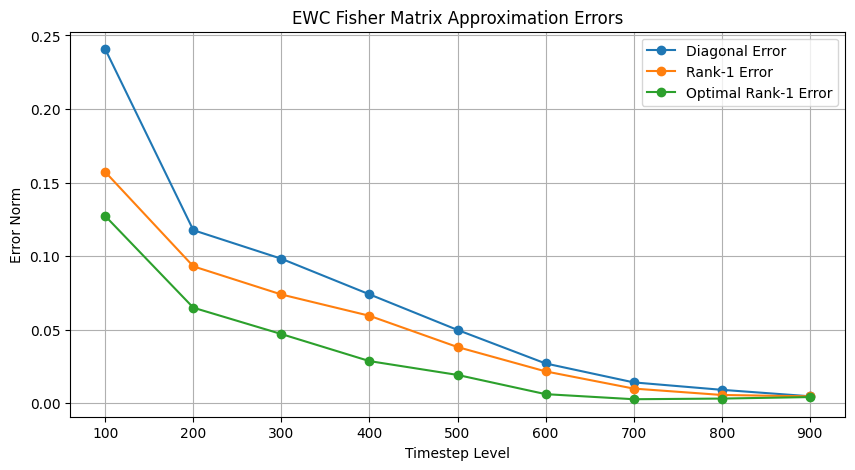

In [13]:
# loop through differnet t_levels
t_levels = [100, 200, 300, 400, 500, 600, 700, 800, 900]
diag_errors = []
rank1_errors = []
rank1_optimal_errors = []
for t_level in t_levels:
    print(f"Computing param scores for t_level={t_level}")
    param_scores = compute_param_scores(
        mnist_model, t_level, cl_mnist_train_loaders, device=device, target_class=0, max_samples=None
    )
    Fisher = empirical_fisher_dense(param_scores).to('cpu')  # (D, D)
    c, mu = optimal_rank1_coeff(param_scores, eps=1e-12, use_float64=False)

    F_diag = torch.diag(torch.diag(Fisher))
    err_diag = torch.linalg.norm(Fisher - F_diag)

    # rank-1 as score
    F_r1_score = mu.unsqueeze(1) @ mu.unsqueeze(0)  # (D, D)
    err_r1_score = torch.linalg.norm(Fisher - F_r1_score)

    F_r1_optimal = mu.unsqueeze(1) @ mu.unsqueeze(0) * c  # (D, D)
    err_r1_optimal = torch.linalg.norm(Fisher - F_r1_optimal)

    diag_errors.append(err_diag.item())
    rank1_errors.append(err_r1_score.item())
    rank1_optimal_errors.append(err_r1_optimal.item())

# plot errors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(t_levels, diag_errors, label='Diagonal Error', marker='o')
plt.plot(t_levels, rank1_errors, label='Rank-1 Error', marker='o')
plt.plot(t_levels, rank1_optimal_errors, label='Optimal Rank-1 Error', marker='o')
plt.xlabel('Timestep Level')
plt.ylabel('Error Norm')
plt.title('EWC Fisher Matrix Approximation Errors')
plt.legend()
plt.grid()
plt.savefig(ROOT / "ewc_fisher_errors.png")
plt.show()

In [14]:
print("Diagonal Errors:", diag_errors)
print("Rank-1 Errors:", rank1_errors)
print("Optimal Rank-1 Errors:", rank1_optimal_errors)

Diagonal Errors: [0.240617036819458, 0.1176314428448677, 0.09819727391004562, 0.07399624586105347, 0.04979902505874634, 0.027024835348129272, 0.014157526195049286, 0.009110557846724987, 0.004728379193693399]
Rank-1 Errors: [0.15717117488384247, 0.09304080903530121, 0.07390189170837402, 0.059429511427879333, 0.03818073123693466, 0.0216315146535635, 0.009947557002305984, 0.005607550963759422, 0.004664273466914892]
Optimal Rank-1 Errors: [0.1272253841161728, 0.06493214517831802, 0.0470103845000267, 0.02863071858882904, 0.01922937110066414, 0.006164396647363901, 0.0027159666642546654, 0.0031556030735373497, 0.004175945650786161]


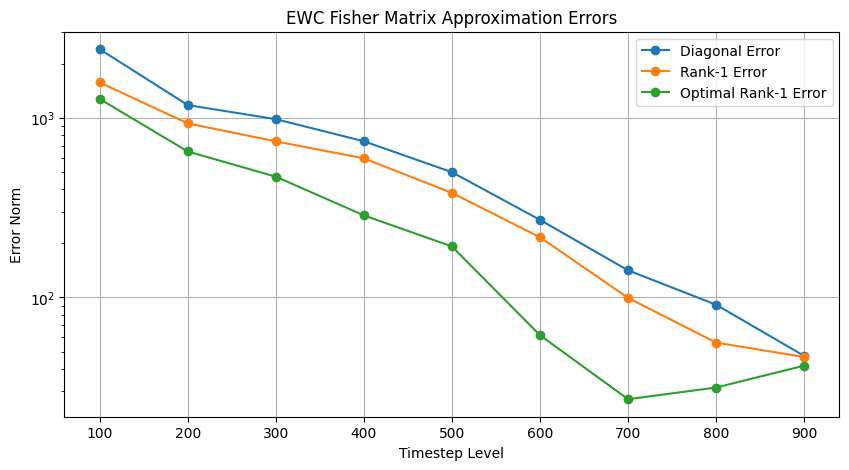

In [19]:
# plot errors
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(t_levels, np.array(diag_errors)*10000, label='Diagonal Error', marker='o')
plt.plot(t_levels, np.array(rank1_errors)*10000, label='Rank-1 Error', marker='o')
plt.plot(t_levels, np.array(rank1_optimal_errors)*10000, label='Optimal Rank-1 Error', marker='o')
# log scale y
plt.yscale('log')
plt.xlabel('Timestep Level')
plt.ylabel('Error Norm')
plt.title('EWC Fisher Matrix Approximation Errors')
plt.legend()
plt.grid()
# plt.savefig(ROOT / "ewc_fisher_errors.png")
plt.show()

In [28]:
# assume Fisher is your [D×D] matrix on CPU or GPU
F = Fisher.to('cpu')  # ensure Fisher is on the same device as scores
print(F.shape, param_scores.shape)
param_scores = param_scores.to('cpu')  # ensure param_scores is on the same device as Fisher


# 2.2 Frobenius‐norm error of diagonal
F_diag = torch.diag(torch.diag(F))
err_diag = torch.linalg.norm(F - F_diag)


# 2.4 rank-1 as score
# F_r1_score = param_scores.mean(dim=0).unsqueeze(1) @ param_scores.mean(dim=0).unsqueeze(0)
F_r1_score = mu.unsqueeze(1) @ mu.unsqueeze(0) * c  # (D, D)
err_r1_score = torch.linalg.norm(F - F_r1_score)

print(f"‖F-F_diag‖_F = {err_diag:.10f},  ‖F-F_r1_score‖_F = {err_r1_score:.10f}")


torch.Size([68881, 68881]) torch.Size([12665, 68881])
‖F-F_diag‖_F = 0.0372062847,  ‖F-F_r1_score‖_F = 0.0157281570


In [ ]:
# approx large Fisher with rank-1


# test FID

In [13]:
fid_eval = utils.FIDEvaluator(device=device)
fid_mnist = fid_eval.fid_loader_vs_model(cl_cifar_test_loaders[0], cifar_model)
print(f"FID (MNIST train vs samples): {fid_mnist:.3f}")

FID (MNIST train vs samples): 36.637


In [14]:
mnist_model.load_state_dict(torch.load( ROOT / "mnist_model_large-task1-rank1_opt.pth", map_location=device))
fid_eval = utils.FIDEvaluator(device=device)
fid_mnist = fid_eval.fid_loader_vs_model(cl_mnist_test_loaders[0], mnist_model)
print(f"FID (MNIST train vs samples): {fid_mnist:.3f}")

FID (MNIST train vs samples): 169.732


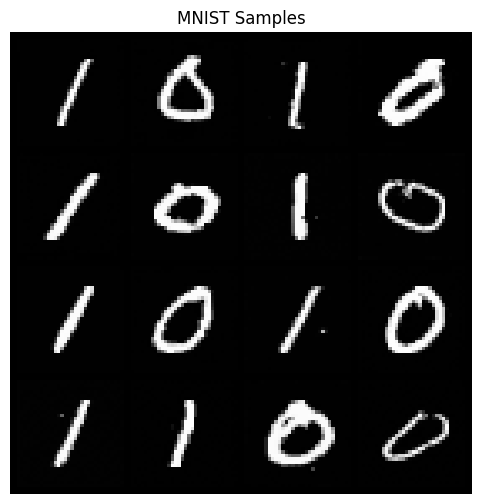

In [26]:
# test mnist model sampling
import matplotlib.pyplot as plt
# random labels between 0 and 1
n_samples = 16
labels = torch.randint(0, 2, (n_samples,), device=device)
samples = mnist_model.sample(n_samples, labels=labels, num_inference_steps=50, device=device, seed=123)
samples = (samples + 1) / 2  # to [0, 1]
grid_img = utils.make_grid(samples, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title("MNIST Samples")
# plt.savefig(ROOT / "mnist_samples.png")
plt.show()

In [11]:
cl_mnist_test_loaders.keys()

dict_keys([0, 1, 2, 3, 4])